# Euler Method

In [1]:
from typing import Callable, NamedTuple
from functools import cache

import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import sympy as sy
from tqdm import tqdm

from ipywidgets.widgets import interact, FloatSlider, Layout

In [2]:
np.set_printoptions(suppress=True)

plt.style.use("bmh")
config = {'figure.figsize': (18, 4),
          'axes.titlesize': 18,
          'axes.labelsize': 10,
          'lines.linewidth': 2,
          'lines.markersize': 10,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'axes.prop_cycle': plt.cycler(color=["darkmagenta", "saddlebrown", "darkcyan", "olivedrab", "darkseagreen", "darkkhaki", "darkgoldenrod", "deepskyblue", "firebrick", "palevioletred"]),}
plt.rcParams.update(config)

In [131]:
Function = Callable[[sy.Symbol, sy.Symbol], sy.Expr]

ODESolver = Callable[["ODEInfo"], tuple[npt.ArrayLike, npt.ArrayLike]]

class ODEInfo(NamedTuple):
    matrix: npt.ArrayLike
    initial_value: npt.ArrayLike
    time_step: float
    time_final: float
    title: str | None = None

    @property
    def number_of_steps(self) -> int:
        return int(self.time_final / self.time_step)
    
    @property
    def time(self) -> npt.NDArray[np.float32]:
        return np.linspace(0, self.time_final, self.number_of_steps) 

    @property
    def as_lambda(self) -> Callable[[npt.NDArray[np.complex128]], npt.NDArray[np.complex128]]:
        y_sym = sy.Function('y')
        x_sym = sy.Symbol('x')

        symbolic_function = self.function(x_sym, y_sym(x_sym))
        equation = sy.Eq(symbolic_function, y_sym(x_sym).diff(x_sym))

        solution = sy.dsolve(equation, ics={y_sym(0): self.initial_value})
        return sy.lambdify(x_sym, solution.rhs, 'numpy')

    @cache
    def solve(self, solver: ODESolver) -> tuple[npt.ArrayLike, npt.ArrayLike]:
        return solver(self)
    
    @cache
    def solve_analytical(self) -> tuple[npt.ArrayLike, npt.ArrayLike]:
        return self.time, self.as_lambda(self.time)
    
    @property
    def number_of_variables(self) -> int:
        return self.matrix.shape[0]
    
    @property
    def associated_identity(self) -> npt.ArrayLike:
        return np.eye(self.number_of_variables)
    
    @property
    def base_solution_matrix(self) -> npt.ArrayLike:
        solution_matrix = np.zeros((self.number_of_variables, self.number_of_steps), dtype=np.complex128)
        solution_matrix[:, 0] = self.initial_value
        return solution_matrix

## Explicit Euler Method

In [132]:
def euler_explicit(info: ODEInfo) -> tuple[npt.ArrayLike, npt.ArrayLike]:
    steps = np.arange(0, info.number_of_steps)
    step_factor = (info.associated_identity + info.time_step * info.matrix)
    solution_matrix = (step_factor ** steps).T @ info.initial_value
    return info.time, solution_matrix.T

## Implicit Euler Method

In [133]:
def euler_implicit(info: ODEInfo) -> tuple[npt.NDArray[np.float32], npt.NDArray[np.float32]]:
    steps = np.arange(0, info.number_of_steps)
    step_factor = np.linalg.pinv(info.associated_identity - info.matrix * info.time_step)
    solution_matrix = (step_factor ** steps).T @ info.initial_value
    return info.time, solution_matrix.T

## Parametrization

In [134]:
def variation_h(h: float, real_coefficient: float, imaginary_coefficient: float, max_time: int):
    coefficient = (real_coefficient + imaginary_coefficient * 1j)
    ode_info = ODEInfo(np.array([[coefficient]]), np.array([[35]]), h, max_time)

    x_explicit, y_explicit = euler_explicit(ode_info)
    x_implicit, y_implicit = euler_implicit(ode_info)

    # xs = np.linspace(0, ode_info.time_final, 1000)
    # ys = ode_info.as_lambda(xs)

    # plt.plot(xs, ys, label='Analytic Solution', alpha=0.4, lw=5)

    plt.plot(x_explicit, np.real(y_explicit[0, :]), 'o--', markersize=8, label='Approximation (Explicit)', color='darkcyan')
    plt.plot(x_implicit, np.real(y_implicit[0, :]), 'o--', markersize=8, label='Approximation (Implicit)', color='firebrick')

    plt.title('Euler Method - Variation of $h$')
    plt.xlabel('t')
    plt.ylabel('f(t)')

    plt.legend()


    plt.tight_layout()
    plt.show()
    
interact(variation_h, 
    h=FloatSlider(min=0, max=4, step=0.01, value=0.5, layout=Layout(width='99%')),
    real_coefficient=FloatSlider(min=-3, max=3, step=0.1, value=-1, layout=Layout(width='99%')),
    imaginary_coefficient=FloatSlider(min=-3, max=3, step=0.1, value=0, layout=Layout(width='99%')),
    max_time=FloatSlider(min=1, max=50, step=1, value=20, layout=Layout(width='99%')),
);

interactive(children=(FloatSlider(value=0.5, description='h', layout=Layout(width='99%'), max=4.0, step=0.01),…

## Examples

In [59]:
odes = [
    ODEInfo(lambda x, y: 0.1*y, 1, 1, 20, "$y' = 0.1 y$"),
    ODEInfo(lambda x, y: 2*x - 2*y, 1, 0.1, 5, "$y' = 2x - 2y$"),
    ODEInfo(lambda x, y: x*y**2 + 2*y, -5, 0.1, 5, "$y' = xy^2 + 2y$"),
]

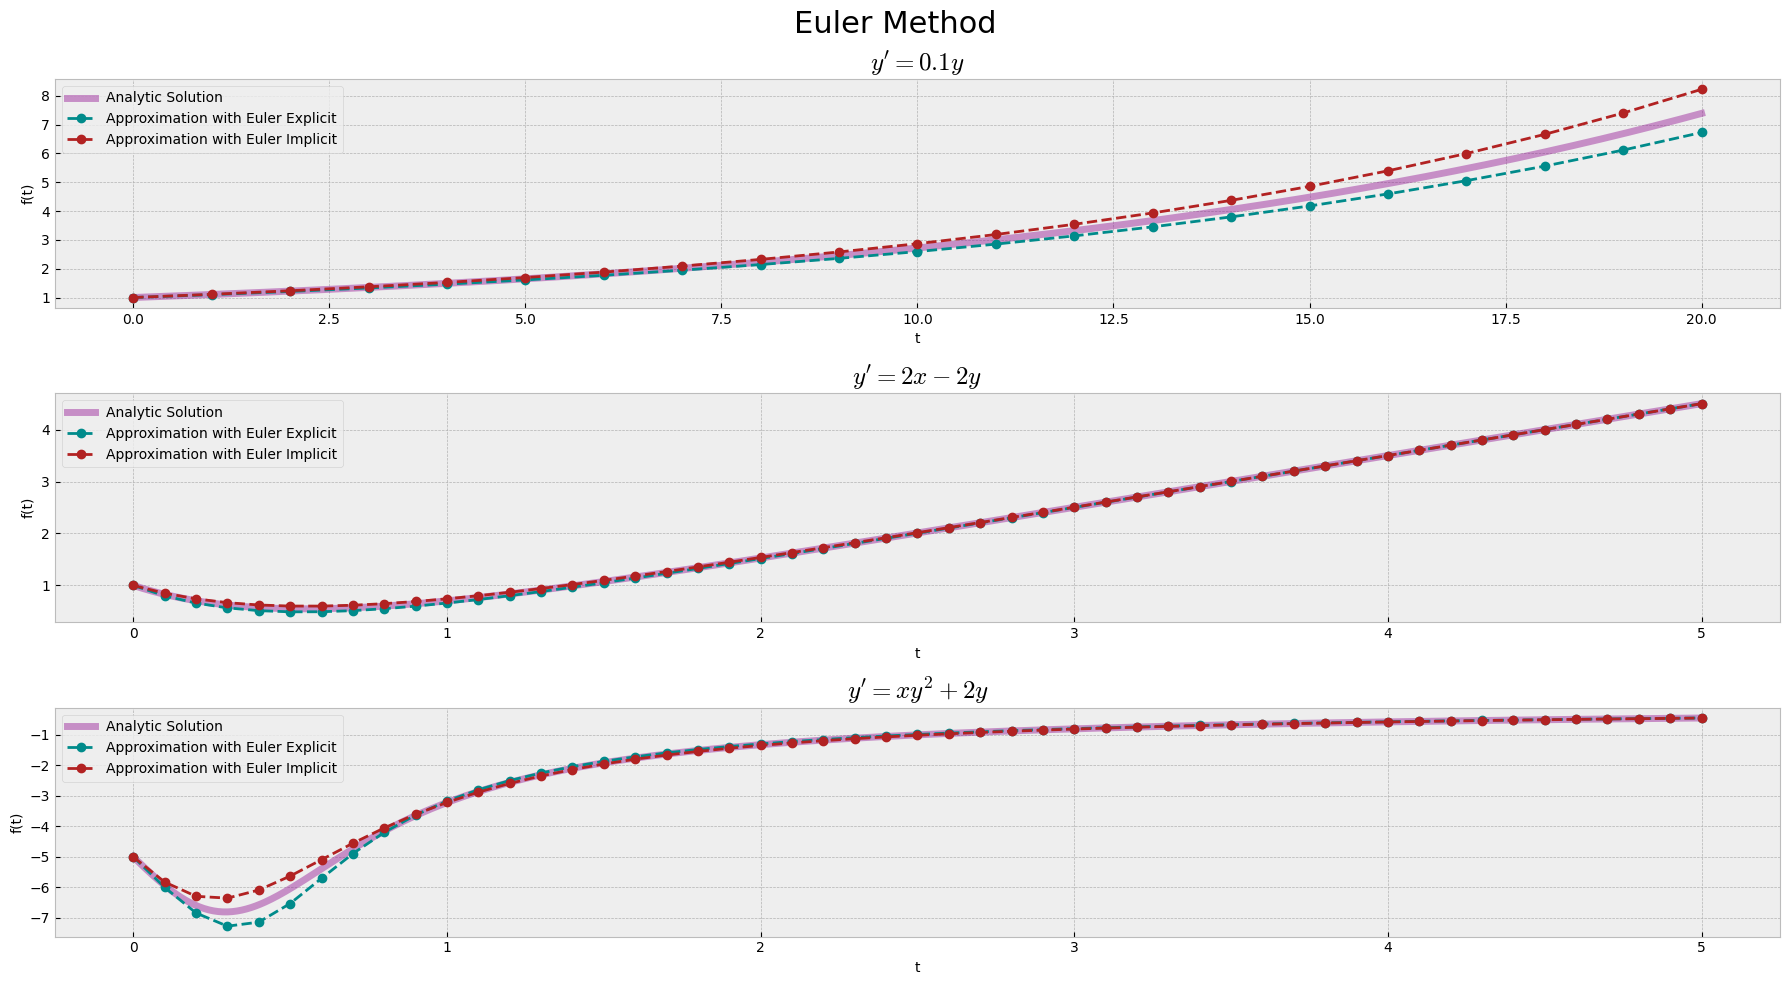

In [60]:
fig, axes = plt.subplots(3, 1, figsize=(18, 10))

for ax, ode in zip(axes.flatten(), odes):
    x_explicit, y_solution = euler_explicit(ode)
    x_implicit, y_implicit = euler_implicit(ode)
    
    xs = np.linspace(0, ode.time_final, 1000)
    ys = ode.as_lambda(xs)

    ax.plot(xs, ys, label='Analytic Solution', alpha=0.4, lw=5)

    ax.plot(x_explicit, y_solution, 'o--', markersize=6, label='Approximation with Euler Explicit', color='darkcyan')
    ax.plot(x_implicit, y_implicit, 'o--', markersize=6, label='Approximation with Euler Implicit', color='firebrick')
    
    ax.set_title(ode.title)
    ax.set_xlabel('t')
    ax.set_ylabel('f(t)')
    
    ax.legend()

plt.suptitle('Euler Method', fontsize=22)
plt.tight_layout()
plt.show()

En el gráfico anterior se puede ver como el implícito siempre aproxima por encima y el explícito por debajo